# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

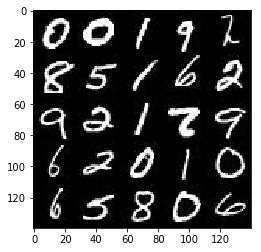

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

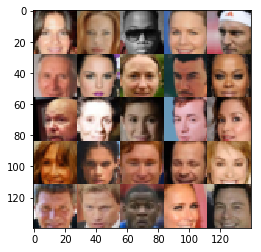

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr_rate = tf.placeholder(tf.float32)
    
    return (inputs_real, inputs_z, lr_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def lrelu(x, alpha=0.2):
    """Leaky ReLu implementation"""
    return tf.maximum(alpha * x, x)

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2
    input_shape = images.get_shape().as_list()[2]
    final_shape = input_shape // 4
    flat_shape = (-1, final_shape * final_shape * 512)
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input as image batch
        net = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        net = tf.maximum(alpha * net, net)
        # First convolution with 64 filters
        
        net = tf.layers.conv2d(net, 128, 5, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = lrelu(net)
        # Second convolution with 128 filters
        
        net = tf.layers.conv2d(net, 512, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = lrelu(net)
        # Second convolution with 512 filters
        
        # Flatten layers
        net = tf.reshape(net, flat_shape)
        logits = tf.layers.dense(net, 1)
        outputs = tf.sigmoid(logits)
        
        
    return (outputs, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # Flat layer
        net = tf.layers.dense(z, 7*7*512)
        net = tf.reshape(net, (-1, 7, 7, 512))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = lrelu(net)
        
        # Deconvolution for 256 filters 14 X 14 shape
        net = tf.layers.conv2d_transpose(net, 256, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = lrelu(net)
        
        # Deconvolution for 128 filters 14 X 14 shape
        net = tf.layers.conv2d_transpose(net, 128, 5, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = lrelu(net)
        
        # Deconvolution for out_channel_dim filters 28 X 28 shape
        net = tf.layers.conv2d_transpose(net, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(net)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    (d_model_real, d_logits_real) = discriminator(input_real)
    (d_model_fake, d_logits_fake) = discriminator(g_model, reuse=True)
    
    # Discriminator loss
    d_labels_real = tf.ones_like(d_model_real)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    d_labels_fake = tf.zeros_like(d_model_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_labels = tf.ones_like(d_model_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    tr_vars = tf.trainable_variables()
    g_vars = [var for var in tr_vars if var.name.startswith('generator')]
    d_vars = [var for var in tr_vars if var.name.startswith('discriminator')]
    
    # I think one could use tf.get_collection((tf.GraphKeys.TRAINABLE_VARIABLES, ...) 
    # but this one (list comprehension) seems more self explanatory
    
    # Training optimizers for appropriated variables
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        genr_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return (disc_train_opt, genr_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = data_shape[3]
    (input_real, input_z, lr_rate) = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    (d_loss, g_loss) = model_loss(input_real, input_z, out_channel_dim)
    (d_opt, g_opt) = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    saver = tf.train.Saver()
    sample_size = 25
    file_prfx = 'celeb_' if data_image_mode == 'RGB' else 'mnist_'
    chkp_file_path = './checkpoints/' + file_prfx + 'generator.ckpt'

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Normalize images
                norm_batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                train_feed_dict = {input_real: norm_batch_images, input_z: batch_z, lr_rate: learning_rate}
                # Run optimizers
                # For discriminator
                _ = sess.run(d_opt, feed_dict=train_feed_dict)
                # For generator
                for _ in range(2):
                    _ = sess.run(g_opt, feed_dict=train_feed_dict)
                
                if steps % 10 == 0:
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: norm_batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:  
                    # Show samples
                    show_generator_output(sess, sample_size, input_z, out_channel_dim, data_image_mode)
        saver.save(sess, chkp_file_path)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 7.0759... Generator Loss: 0.1053
Epoch 1/2... Discriminator Loss: 6.0292... Generator Loss: 3.1019
Epoch 1/2... Discriminator Loss: 3.4883... Generator Loss: 1.5178
Epoch 1/2... Discriminator Loss: 3.5386... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 3.3986... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 2.9084... Generator Loss: 1.1204
Epoch 1/2... Discriminator Loss: 2.6754... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 2.9315... Generator Loss: 0.9398
Epoch 1/2... Discriminator Loss: 3.1882... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 2.5418... Generator Loss: 0.8836


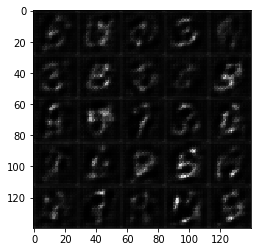

Epoch 1/2... Discriminator Loss: 3.1903... Generator Loss: 1.0243
Epoch 1/2... Discriminator Loss: 2.7576... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 2.1937... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 2.6306... Generator Loss: 0.9251
Epoch 1/2... Discriminator Loss: 2.3496... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 2.0997... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 2.4139... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.8904... Generator Loss: 0.3061
Epoch 1/2... Discriminator Loss: 2.6507... Generator Loss: 0.9795
Epoch 1/2... Discriminator Loss: 1.5794... Generator Loss: 0.6133


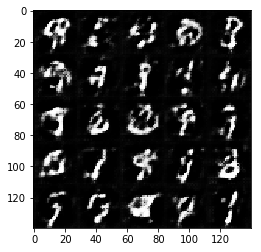

Epoch 1/2... Discriminator Loss: 2.3053... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 2.1077... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 2.0622... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 2.4716... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 2.2461... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 2.4751... Generator Loss: 0.1485
Epoch 1/2... Discriminator Loss: 2.0884... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 1.9311... Generator Loss: 0.2989
Epoch 1/2... Discriminator Loss: 2.1406... Generator Loss: 0.3360


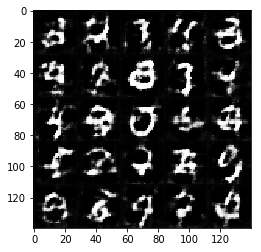

Epoch 1/2... Discriminator Loss: 2.3207... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.8963... Generator Loss: 0.2411
Epoch 1/2... Discriminator Loss: 1.9886... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 2.2484... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 2.0560... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 2.1701... Generator Loss: 0.1712
Epoch 1/2... Discriminator Loss: 2.1653... Generator Loss: 0.1863
Epoch 1/2... Discriminator Loss: 2.3949... Generator Loss: 0.1939
Epoch 1/2... Discriminator Loss: 2.1320... Generator Loss: 0.2617
Epoch 1/2... Discriminator Loss: 2.4285... Generator Loss: 0.1686


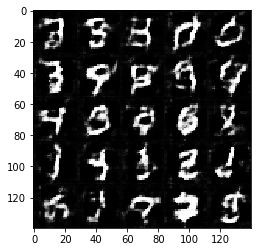

Epoch 1/2... Discriminator Loss: 2.0118... Generator Loss: 1.1907
Epoch 1/2... Discriminator Loss: 2.0279... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 2.0799... Generator Loss: 1.9559
Epoch 1/2... Discriminator Loss: 1.7768... Generator Loss: 0.7506
Epoch 1/2... Discriminator Loss: 1.7078... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.8469... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.8022... Generator Loss: 0.4425
Epoch 1/2... Discriminator Loss: 1.8741... Generator Loss: 1.1746
Epoch 1/2... Discriminator Loss: 1.6632... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.9542... Generator Loss: 1.3413


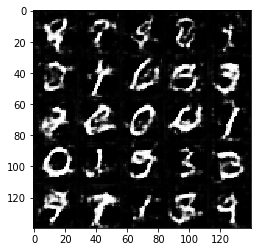

Epoch 1/2... Discriminator Loss: 1.8923... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 1.7144... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.8705... Generator Loss: 0.9440
Epoch 1/2... Discriminator Loss: 1.9519... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 1.9918... Generator Loss: 0.2750
Epoch 1/2... Discriminator Loss: 2.4881... Generator Loss: 0.2025
Epoch 1/2... Discriminator Loss: 2.0676... Generator Loss: 0.2580
Epoch 1/2... Discriminator Loss: 1.8325... Generator Loss: 0.2876
Epoch 1/2... Discriminator Loss: 1.9870... Generator Loss: 0.2326
Epoch 1/2... Discriminator Loss: 2.0647... Generator Loss: 0.1829


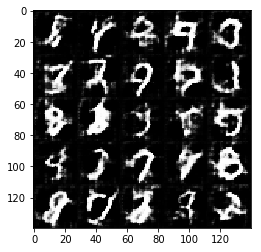

Epoch 1/2... Discriminator Loss: 1.6621... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.8482... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 2.9774... Generator Loss: 0.0997
Epoch 1/2... Discriminator Loss: 1.7132... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 2.8078... Generator Loss: 0.1039
Epoch 1/2... Discriminator Loss: 1.8955... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 1.7412... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.8811... Generator Loss: 0.2645
Epoch 1/2... Discriminator Loss: 1.8582... Generator Loss: 0.9346
Epoch 1/2... Discriminator Loss: 1.9995... Generator Loss: 1.1083


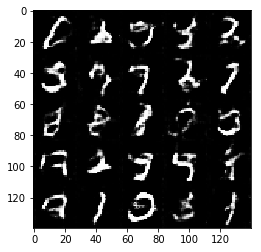

Epoch 1/2... Discriminator Loss: 2.2932... Generator Loss: 1.3890
Epoch 1/2... Discriminator Loss: 1.8222... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 2.4273... Generator Loss: 1.5304
Epoch 1/2... Discriminator Loss: 2.1844... Generator Loss: 0.4706
Epoch 1/2... Discriminator Loss: 1.9811... Generator Loss: 0.2468
Epoch 1/2... Discriminator Loss: 1.9133... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 1.7904... Generator Loss: 0.3309
Epoch 1/2... Discriminator Loss: 2.0779... Generator Loss: 0.1845
Epoch 1/2... Discriminator Loss: 2.0972... Generator Loss: 0.1835
Epoch 1/2... Discriminator Loss: 2.2235... Generator Loss: 0.1753


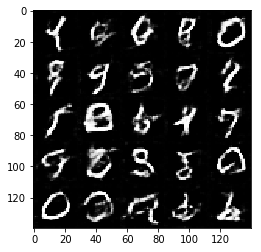

Epoch 1/2... Discriminator Loss: 1.6158... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.8356... Generator Loss: 0.4158
Epoch 1/2... Discriminator Loss: 1.8083... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.9492... Generator Loss: 1.0381
Epoch 1/2... Discriminator Loss: 1.6921... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 2.2124... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 2.1476... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 1.8600... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.7075... Generator Loss: 0.5244
Epoch 1/2... Discriminator Loss: 2.0521... Generator Loss: 0.2704


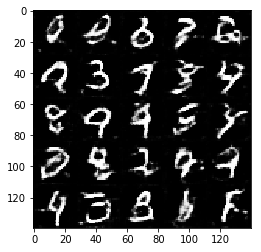

Epoch 1/2... Discriminator Loss: 1.8511... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.7855... Generator Loss: 0.3455
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 1.7204... Generator Loss: 0.3764
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.5815
Epoch 1/2... Discriminator Loss: 1.8945... Generator Loss: 0.3187
Epoch 1/2... Discriminator Loss: 1.6021... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 2.1903... Generator Loss: 1.0460


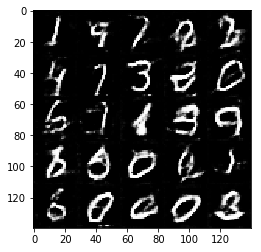

Epoch 1/2... Discriminator Loss: 2.3337... Generator Loss: 0.1407
Epoch 1/2... Discriminator Loss: 2.0341... Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 1.7438... Generator Loss: 0.5456
Epoch 1/2... Discriminator Loss: 2.0342... Generator Loss: 0.2184
Epoch 1/2... Discriminator Loss: 1.7457... Generator Loss: 0.3802
Epoch 1/2... Discriminator Loss: 1.7246... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 2.2396... Generator Loss: 0.1714
Epoch 1/2... Discriminator Loss: 2.0481... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 2.3129... Generator Loss: 0.1682
Epoch 1/2... Discriminator Loss: 2.1659... Generator Loss: 0.2466


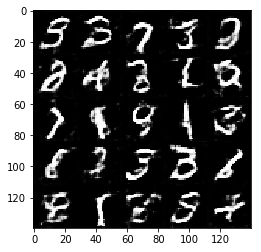

Epoch 1/2... Discriminator Loss: 2.4533... Generator Loss: 2.0285
Epoch 1/2... Discriminator Loss: 1.6164... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.6744... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.8032... Generator Loss: 1.1038
Epoch 1/2... Discriminator Loss: 2.1073... Generator Loss: 0.2039
Epoch 1/2... Discriminator Loss: 2.5863... Generator Loss: 0.1081
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 2.2372... Generator Loss: 0.1512
Epoch 1/2... Discriminator Loss: 2.3273... Generator Loss: 0.3294
Epoch 1/2... Discriminator Loss: 1.9811... Generator Loss: 0.2191


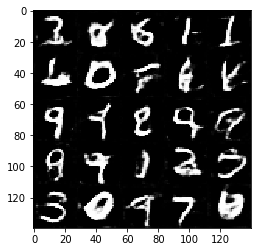

Epoch 1/2... Discriminator Loss: 1.6534... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 3.2574... Generator Loss: 0.0890
Epoch 1/2... Discriminator Loss: 1.9730... Generator Loss: 0.2860
Epoch 1/2... Discriminator Loss: 1.7102... Generator Loss: 0.3087
Epoch 1/2... Discriminator Loss: 1.9793... Generator Loss: 0.1979
Epoch 1/2... Discriminator Loss: 1.5896... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 2.0353... Generator Loss: 0.3293
Epoch 1/2... Discriminator Loss: 2.0550... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 1.5758... Generator Loss: 0.4038
Epoch 1/2... Discriminator Loss: 1.9921... Generator Loss: 0.2853


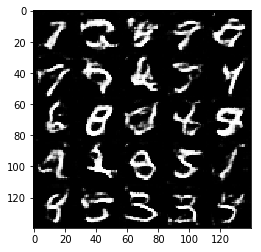

Epoch 1/2... Discriminator Loss: 2.0203... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 2.0237... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 2.0309... Generator Loss: 0.2241
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 2.2526... Generator Loss: 0.1820
Epoch 1/2... Discriminator Loss: 1.6949... Generator Loss: 0.3085
Epoch 1/2... Discriminator Loss: 1.8681... Generator Loss: 0.3611
Epoch 1/2... Discriminator Loss: 2.0424... Generator Loss: 0.4128
Epoch 1/2... Discriminator Loss: 2.1181... Generator Loss: 1.9501


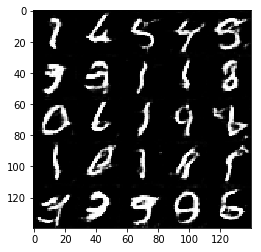

Epoch 1/2... Discriminator Loss: 1.8580... Generator Loss: 0.2970
Epoch 1/2... Discriminator Loss: 1.6025... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.9120... Generator Loss: 0.2458
Epoch 1/2... Discriminator Loss: 1.9409... Generator Loss: 0.2544
Epoch 1/2... Discriminator Loss: 2.4685... Generator Loss: 1.6699
Epoch 1/2... Discriminator Loss: 1.8460... Generator Loss: 1.1973
Epoch 1/2... Discriminator Loss: 1.6447... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 2.1046... Generator Loss: 1.5673
Epoch 1/2... Discriminator Loss: 2.4398... Generator Loss: 0.1233


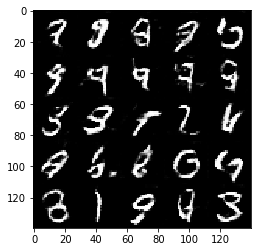

Epoch 1/2... Discriminator Loss: 1.7607... Generator Loss: 0.2747
Epoch 1/2... Discriminator Loss: 2.0364... Generator Loss: 0.2134
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 2.2939... Generator Loss: 0.1408
Epoch 1/2... Discriminator Loss: 1.5669... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 2.0456... Generator Loss: 0.2155
Epoch 1/2... Discriminator Loss: 1.6325... Generator Loss: 0.3676
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 2.0081... Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 2.3537... Generator Loss: 0.1328


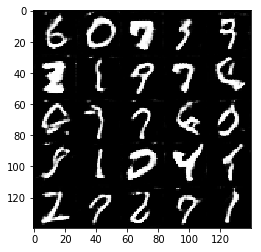

Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.4101
Epoch 1/2... Discriminator Loss: 1.9004... Generator Loss: 1.3219
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 1.1404
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.6657... Generator Loss: 0.4039
Epoch 1/2... Discriminator Loss: 1.6330... Generator Loss: 0.3848
Epoch 1/2... Discriminator Loss: 1.8252... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.6555... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 2.1159... Generator Loss: 0.1694
Epoch 1/2... Discriminator Loss: 2.0954... Generator Loss: 0.1889


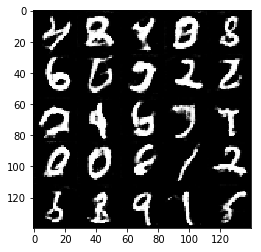

Epoch 1/2... Discriminator Loss: 1.8015... Generator Loss: 0.2546
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 1.8251... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 1.5617
Epoch 1/2... Discriminator Loss: 1.9292... Generator Loss: 1.5192
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.3993
Epoch 1/2... Discriminator Loss: 2.2493... Generator Loss: 0.1786


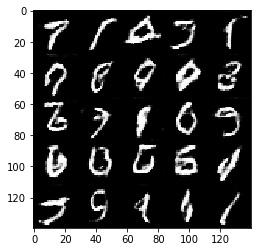

Epoch 1/2... Discriminator Loss: 1.6823... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.9603... Generator Loss: 0.2108
Epoch 1/2... Discriminator Loss: 3.0588... Generator Loss: 0.0626
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.9468... Generator Loss: 0.2126
Epoch 2/2... Discriminator Loss: 1.6307... Generator Loss: 0.3215
Epoch 2/2... Discriminator Loss: 1.9938... Generator Loss: 0.1974
Epoch 2/2... Discriminator Loss: 1.8370... Generator Loss: 0.2354


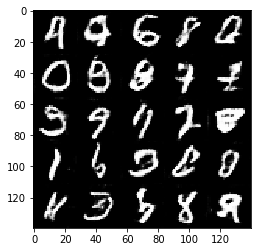

Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 2.1574... Generator Loss: 0.1782
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.9598
Epoch 2/2... Discriminator Loss: 2.3579... Generator Loss: 0.1455
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.5783
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.4233
Epoch 2/2... Discriminator Loss: 2.1482... Generator Loss: 0.1971
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 2.3583... Generator Loss: 0.1360
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.6166


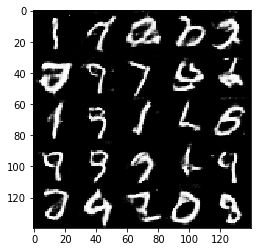

Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.5610
Epoch 2/2... Discriminator Loss: 3.2701... Generator Loss: 0.0659
Epoch 2/2... Discriminator Loss: 2.3614... Generator Loss: 1.4104
Epoch 2/2... Discriminator Loss: 1.5238... Generator Loss: 0.4461
Epoch 2/2... Discriminator Loss: 1.5221... Generator Loss: 0.3148
Epoch 2/2... Discriminator Loss: 2.6220... Generator Loss: 0.1027
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 2.4319... Generator Loss: 0.1185
Epoch 2/2... Discriminator Loss: 1.7573... Generator Loss: 0.2641
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.6028


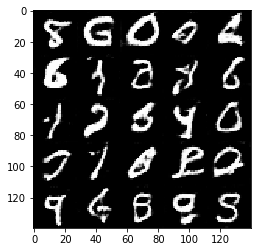

Epoch 2/2... Discriminator Loss: 2.4235... Generator Loss: 2.2973
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.4362
Epoch 2/2... Discriminator Loss: 1.8946... Generator Loss: 1.7877
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 1.5832
Epoch 2/2... Discriminator Loss: 1.7949... Generator Loss: 0.2741
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 1.0427
Epoch 2/2... Discriminator Loss: 1.5709... Generator Loss: 0.3739
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.2152
Epoch 2/2... Discriminator Loss: 1.6859... Generator Loss: 0.2938


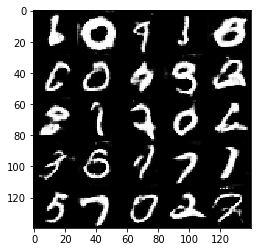

Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 1.1094
Epoch 2/2... Discriminator Loss: 1.6272... Generator Loss: 0.3461
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 1.2500
Epoch 2/2... Discriminator Loss: 2.2371... Generator Loss: 0.1520
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.5048
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.6001... Generator Loss: 0.3936
Epoch 2/2... Discriminator Loss: 1.8697... Generator Loss: 0.2591
Epoch 2/2... Discriminator Loss: 3.7423... Generator Loss: 3.1302
Epoch 2/2... Discriminator Loss: 2.1970... Generator Loss: 0.1720


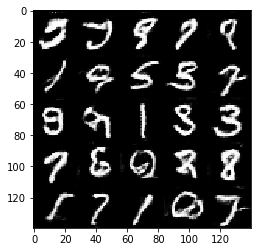

Epoch 2/2... Discriminator Loss: 2.6227... Generator Loss: 0.1143
Epoch 2/2... Discriminator Loss: 2.0017... Generator Loss: 0.2065
Epoch 2/2... Discriminator Loss: 1.8785... Generator Loss: 0.3889
Epoch 2/2... Discriminator Loss: 2.2571... Generator Loss: 0.1617
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.4433
Epoch 2/2... Discriminator Loss: 1.6603... Generator Loss: 0.2990
Epoch 2/2... Discriminator Loss: 1.4824... Generator Loss: 0.3715
Epoch 2/2... Discriminator Loss: 2.7088... Generator Loss: 0.1299
Epoch 2/2... Discriminator Loss: 1.4974... Generator Loss: 0.3764
Epoch 2/2... Discriminator Loss: 1.8806... Generator Loss: 0.2507


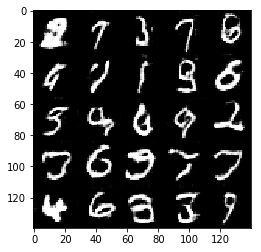

Epoch 2/2... Discriminator Loss: 2.3875... Generator Loss: 0.1823
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 2.1573
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.4594
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.8158... Generator Loss: 1.6860
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 0.3656
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4757


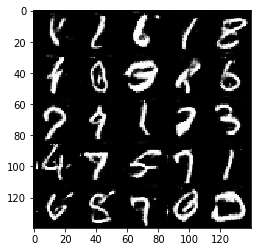

Epoch 2/2... Discriminator Loss: 1.9093... Generator Loss: 0.3474
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 2.4213... Generator Loss: 0.1215
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 2.1388... Generator Loss: 0.2185
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 2.6709... Generator Loss: 0.0887
Epoch 2/2... Discriminator Loss: 1.7354... Generator Loss: 0.4461


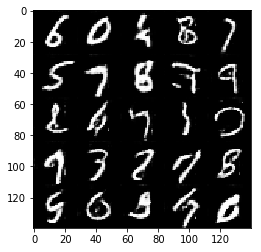

Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.3611
Epoch 2/2... Discriminator Loss: 1.6652... Generator Loss: 1.8536
Epoch 2/2... Discriminator Loss: 2.3798... Generator Loss: 0.1718
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 1.4301... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 1.7443... Generator Loss: 0.3436
Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 1.6231
Epoch 2/2... Discriminator Loss: 1.8975... Generator Loss: 0.2260


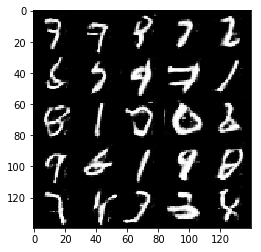

Epoch 2/2... Discriminator Loss: 1.6485... Generator Loss: 0.2919
Epoch 2/2... Discriminator Loss: 1.5102... Generator Loss: 1.1993
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.3792
Epoch 2/2... Discriminator Loss: 1.2458... Generator Loss: 1.7505
Epoch 2/2... Discriminator Loss: 1.7346... Generator Loss: 0.2851
Epoch 2/2... Discriminator Loss: 2.4625... Generator Loss: 0.1910
Epoch 2/2... Discriminator Loss: 1.8019... Generator Loss: 0.3078
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 2.6040... Generator Loss: 0.1496
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.4594


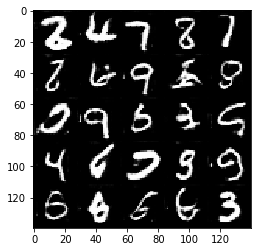

Epoch 2/2... Discriminator Loss: 2.0236... Generator Loss: 0.2973
Epoch 2/2... Discriminator Loss: 1.6584... Generator Loss: 0.3337
Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 1.7071... Generator Loss: 0.2871
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 2.7593
Epoch 2/2... Discriminator Loss: 2.5032... Generator Loss: 0.1168
Epoch 2/2... Discriminator Loss: 1.6137... Generator Loss: 2.4149
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 1.7175... Generator Loss: 0.2828


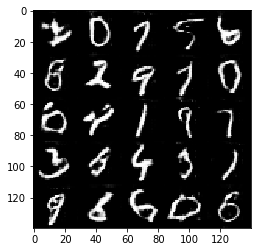

Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 1.3288
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.4245
Epoch 2/2... Discriminator Loss: 2.0270... Generator Loss: 0.1839
Epoch 2/2... Discriminator Loss: 2.0651... Generator Loss: 0.2291
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.6938
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.9448... Generator Loss: 0.2093
Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.4024
Epoch 2/2... Discriminator Loss: 1.8227... Generator Loss: 0.2940


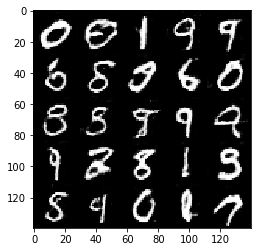

Epoch 2/2... Discriminator Loss: 2.9853... Generator Loss: 3.9900
Epoch 2/2... Discriminator Loss: 1.6623... Generator Loss: 0.3535
Epoch 2/2... Discriminator Loss: 2.9019... Generator Loss: 0.0912
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 2.1662
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.4896
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.9231
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 3.7145
Epoch 2/2... Discriminator Loss: 1.9658... Generator Loss: 1.5801


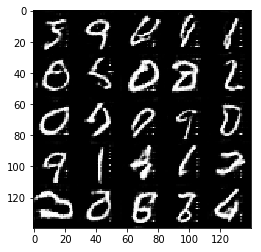

Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.3955
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 1.8732... Generator Loss: 0.2461
Epoch 2/2... Discriminator Loss: 2.6797... Generator Loss: 0.1127
Epoch 2/2... Discriminator Loss: 2.5081... Generator Loss: 0.1315
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.4021
Epoch 2/2... Discriminator Loss: 3.6130... Generator Loss: 0.0505
Epoch 2/2... Discriminator Loss: 2.2485... Generator Loss: 0.1597
Epoch 2/2... Discriminator Loss: 2.5828... Generator Loss: 0.1042


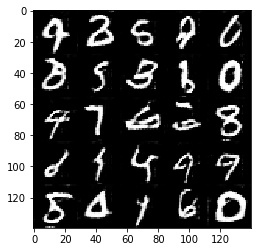

Epoch 2/2... Discriminator Loss: 2.8419... Generator Loss: 0.1108
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.5359... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 0.3343
Epoch 2/2... Discriminator Loss: 2.0505... Generator Loss: 0.2126
Epoch 2/2... Discriminator Loss: 2.4144... Generator Loss: 0.1416
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 1.7181
Epoch 2/2... Discriminator Loss: 1.9386... Generator Loss: 0.2886


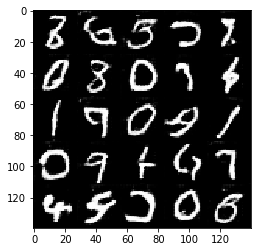

Epoch 2/2... Discriminator Loss: 3.8563... Generator Loss: 0.0495
Epoch 2/2... Discriminator Loss: 2.3163... Generator Loss: 0.1801
Epoch 2/2... Discriminator Loss: 1.8006... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 2.1148... Generator Loss: 0.3624
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.1171... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.7778... Generator Loss: 2.5052
Epoch 2/2... Discriminator Loss: 2.2130... Generator Loss: 1.9818
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 0.6646


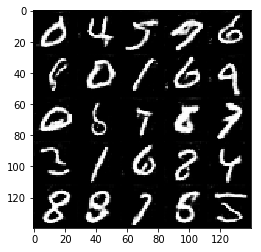

Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.6120
Epoch 2/2... Discriminator Loss: 2.0414... Generator Loss: 0.2433
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.4249
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 1.7587
Epoch 2/2... Discriminator Loss: 1.9335... Generator Loss: 0.2256
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 2.0355
Epoch 2/2... Discriminator Loss: 0.1256... Generator Loss: 4.0398
Epoch 2/2... Discriminator Loss: 1.9868... Generator Loss: 0.2617
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 1.9736


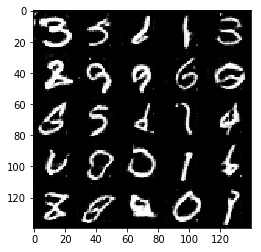

Epoch 2/2... Discriminator Loss: 2.1486... Generator Loss: 0.2243
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.4636
Epoch 2/2... Discriminator Loss: 1.8754... Generator Loss: 0.2866
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.7198... Generator Loss: 0.3043
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 2.0509... Generator Loss: 0.2256


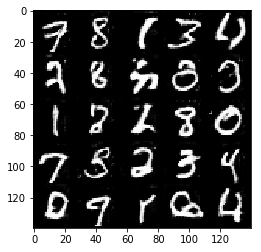

Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.3975
Epoch 2/2... Discriminator Loss: 0.4115... Generator Loss: 1.7144
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 1.3022
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.2325
Epoch 2/2... Discriminator Loss: 2.0829... Generator Loss: 0.2925
Epoch 2/2... Discriminator Loss: 1.7327... Generator Loss: 0.4171
Epoch 2/2... Discriminator Loss: 2.7199... Generator Loss: 0.1727
Epoch 2/2... Discriminator Loss: 2.7423... Generator Loss: 0.1314
Epoch 2/2... Discriminator Loss: 2.1903... Generator Loss: 0.2220


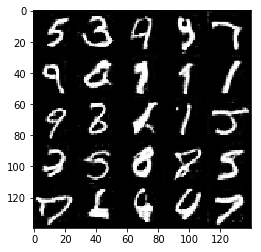

Epoch 2/2... Discriminator Loss: 2.2736... Generator Loss: 0.1617
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.3663
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 1.5558
Epoch 2/2... Discriminator Loss: 2.3461... Generator Loss: 0.1767


In [41]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2384... Generator Loss: 0.1579
Epoch 1/1... Discriminator Loss: 2.9996... Generator Loss: 3.4954
Epoch 1/1... Discriminator Loss: 3.8833... Generator Loss: 0.0658
Epoch 1/1... Discriminator Loss: 2.6239... Generator Loss: 0.2583
Epoch 1/1... Discriminator Loss: 2.8748... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 2.7499... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 2.0887... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 2.0294... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 2.0682... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 2.0319... Generator Loss: 0.5229


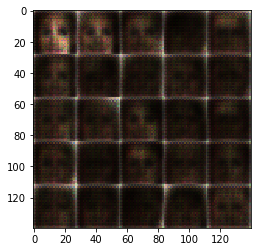

Epoch 1/1... Discriminator Loss: 1.8572... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.7104... Generator Loss: 0.6081


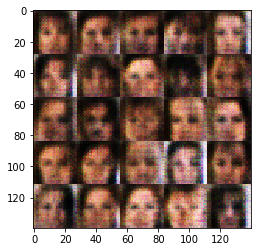

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6811


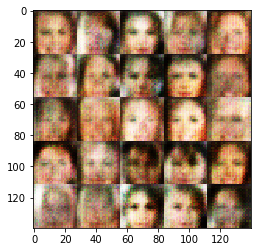

Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.6587... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5716


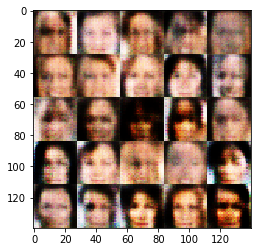

Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.7446


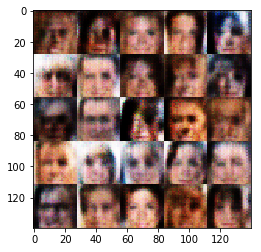

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.7731... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.6587


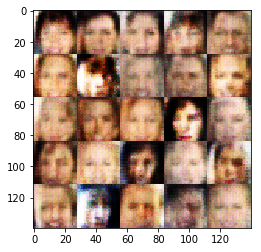

Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6489


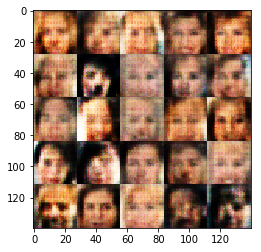

Epoch 1/1... Discriminator Loss: 1.6938... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7205


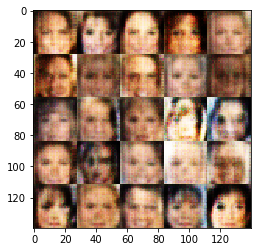

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.6039


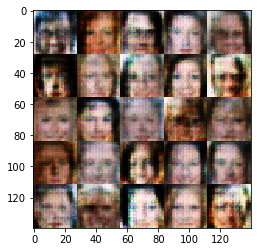

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.6416


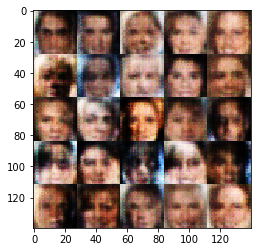

Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6259


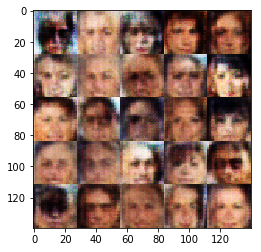

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6987


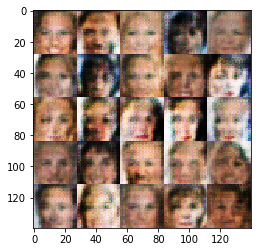

Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6295


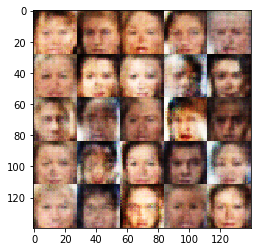

Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6374


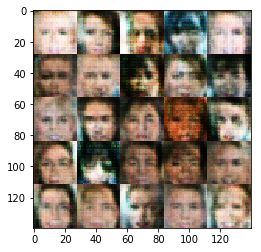

Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.5315


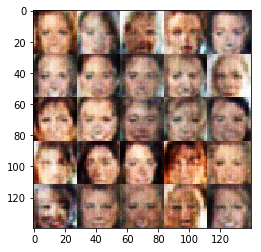

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6163


In [43]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.